In [1]:
import csv
import os.path
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import regularizers
from keras.layers.normalization import BatchNormalization

from rbflayer import RBFLayer, InitCentersRandom
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import *

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn import datasets, linear_model

from rbflayer import RBFLayer, InitCentersRandom
import matplotlib.pyplot as plt
import math
import pandas as pd

D:\Programs\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# loading of dataset 
dataset = []
labels = []
headers = []

def load_dataset_raw():
    global dataset, labels, headers
    with open('OnlineNewsPopularity.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        headers = next(reader) # the first row
        headers = headers[1:]
        headers = [x.strip(' ') for x in headers]    
            
        temp_data = []
        temp_label = []
        for idx, row in enumerate(reader):
            temp_data.append(row[1:])
            temp_label.append(row[-1])

        # convert elements to float        
        for idx, row in enumerate(temp_data):        
            dataset.append([float(i) for i in row[:]])
        for idx, row in enumerate(temp_label):
            labels.append(float(row))   
        
    return np.array(dataset), np.array(labels).reshape(-1, 1)

def load_dataset(is_normalize=True, is_remove_outlier=True, select_top=50):
    """
    is_normalize: To normalize or keep orignal form
    is_remove_outlier: To remove outlier 
    select_top: select top important features using PCA (Principal component analysis)
    """
    global dataset, labels, headers
    dataset, labels = load_dataset_raw()
    print('Original dataset shape: {0}, Labels: {1}'.format(dataset.shape, labels.shape))
    
    fields_to_avoid = [0, 18, 20, 24, 38, 39, 40, 41, 42]
    weekday = [30, 31, 32, 33, 34, 35, 36, 37]
    data_channel = [12, 13, 14, 15, 16, 17]
    fields_to_avoid = fields_to_avoid + weekday + data_channel
    fields_to_avoid = sorted(fields_to_avoid)

    # adjust headers
    sub_headers = []
    for idx, h in enumerate(headers):
        if idx not in fields_to_avoid:
            sub_headers.append(h)
    sub_headers.insert(len(sub_headers) - 1, 'weekday')
    sub_headers.insert(len(sub_headers) - 1, 'data_channel')
    headers = sub_headers
    
    # filter columns and categorical fields
    new_dataset = []        
    for idx, row in enumerate(dataset):
        slice_row = [i for num,i in enumerate(row) if num not in fields_to_avoid]
        insert_idx = len(slice_row) - 1

        for col_idx in range(len(row)):
            # convert week day to categorical 
            if col_idx in weekday and row[col_idx] == 1:
                if col_idx == 30:
                    slice_row.insert(insert_idx, 1)
                elif col_idx == 31:
                    slice_row.insert(insert_idx, 2)
                elif col_idx == 32:
                    slice_row.insert(insert_idx, 3)
                elif col_idx == 33:
                    slice_row.insert(insert_idx, 4)
                elif col_idx == 34:
                    slice_row.insert(insert_idx, 5)
                elif col_idx == 35:
                    slice_row.insert(insert_idx, 6)
                elif col_idx == 36:
                    slice_row.insert(insert_idx, 7)

            # convert data channel to categorical 
            if col_idx in data_channel and row[col_idx] == 1:
                if col_idx == 12:
                    slice_row.insert(insert_idx, 1)
                elif col_idx == 13:
                    slice_row.insert(insert_idx, 2)
                elif col_idx == 14:
                    slice_row.insert(insert_idx, 3)
                elif col_idx == 15:
                    slice_row.insert(insert_idx, 4)
                elif col_idx == 16:
                    slice_row.insert(insert_idx, 5)
                elif col_idx == 17:
                    slice_row.insert(insert_idx, 6)

        # handle missing data
        if len(slice_row) == 38:
            slice_row.append(0)
        new_dataset.append(slice_row)         
    
    # copy filter new_dataset to dataset 
    dataset = new_dataset
    
    # normalizing in dataset
    if is_normalize:
        # it is important which type of normalization method you use
        scaler = preprocessing.MinMaxScaler()
        dataset = scaler.fit_transform(dataset)
        # last item uses MinMaxScaler
        labels = np.array(labels).reshape(-1, 1)
        scaler = preprocessing.QuantileTransformer()
        labels = scaler.fit_transform(labels)
        print('Data is normalize')
    else:
        print('No normalize apply')        

    # remove outlier in dataset
    if is_remove_outlier:
        dataset, labels = reject_outliers(dataset, labels)    

    # applying PCA in dataset
    if 0 < select_top < len(dataset[0]):
        top_features = pca_important_features(dataset, headers, top=select_top)
        feature_keys = [f[1] for f in top_features]
        df = pd.DataFrame(dataset, columns=headers)
        top_dataset = []
        for name in feature_keys:
            top_dataset.append(df.loc[:, name])
        dataset = np.transpose(top_dataset)
        
    return np.array(dataset), np.array(labels).reshape(-1, 1)

def pca_important_features(dataset, headers, top=10):
    scaleFeatures = True
    pca = PCA(n_components=top)
    projected  = pca.fit_transform(dataset)
    top_features = extract_features(projected, pca.components_, headers, top)
    return top_features
    
def extract_features(transformed_features, components_, columns, top):
    num_columns = len(columns)

    # This funtion will project your *original* feature (columns)
    # onto your principal component feature-space, so that you can
    # visualize how "important" each one was in the
    # multi-dimensional scaling

    # Scale the principal components by the max value in
    # the transformed set belonging to that component
    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])

    # Sort each column by it's length. These are your *original*
    # columns, not the principal components.
    important_features = { columns[i] : math.sqrt(xvector[i]**2 + yvector[i]**2) for i in range(num_columns) }
    important_features = sorted(zip(important_features.values(), important_features.keys()), reverse=True)
    print("Features by top {0} importance:".format(top))
    for feature in important_features[:top]:
        print(feature)
    print()
    return important_features[:top]
        
def reject_outliers(dataset, labels, m=50):        
    """
    Higher the value 'm' more outliers
    """
    d = np.abs(labels - np.median(labels))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
        
    # remove outliers in dataset and labels
    sub_dataset = []
    sub_labels = []
    outlier_labels = []
    for idx, item in enumerate(s):        
        if item < m:
            sub_labels.append(labels[idx])
            sub_dataset.append(dataset[idx])        
        else:
            outlier_labels.append(labels[idx])
    print('Outlier removed: {0}'.format(len(outlier_labels)))
    return sub_dataset, sub_labels

In [3]:
histories = []
for i in range(1, 11):
    l2_kernal = 0.0001

    # load pretrained MLP weights
    model = Sequential()
    model.add(Dense(128, input_dim=39, activation='relu', kernel_regularizer=regularizers.l2(l2_kernal)))
    model.add(Dropout(0.5))
    model.add(Dense(20, activation='relu', kernel_regularizer=regularizers.l2(l2_kernal)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', activity_regularizer=regularizers.l2(l2_kernal)))

    model.compile(loss='mean_squared_error',
                  optimizer=Adam(lr=0.001),
                  metrics=['mse'])

    saved_weights_name = 'best_features_extraction_rbf.h5'
    if os.path.isfile(saved_weights_name):
        model.load_weights(saved_weights_name)
        print("Weights loaded: {0}".format(saved_weights_name))

    # modify extraction network final layer
    for layer in model.layers:
        layer.trainable = False

    model.layers.pop()
    model.outputs = [model.layers[-1].output]

    # Add RBL layer to model
    rbflayer = RBFLayer(20,
                        betas=0.1,
                        input_shape=(20,))
    model.add(rbflayer)
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='mean_squared_error',
                  optimizer=Adam(lr=0.001),
                  metrics=['mse'])

    # training with callbacks
    saved_weights_name = 'best_weights_rbf.h5'

    if os.path.isfile(saved_weights_name):
        model.load_weights(saved_weights_name)
        print("Weights loaded: {0}".format(saved_weights_name))

    # kfold on dataset and training
    dataset = []
    labels = []
    dataset, labels = load_dataset(is_normalize=True)
    print('Dataset shape: {0}, Labels: {1}'.format(dataset.shape, labels.shape))

    x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, shuffle=False, random_state=42)
    print("x_train: {0}, y_train: {1}".format(x_train.shape, y_train.shape))
    print("x_test: {0}, y_test: {1}".format(x_test.shape, y_test.shape))

    sub_x_train = x_train[0: int(len(x_train) * (i / 10))]
    sub_y_train = y_train[0: int(len(y_train) * (i / 10))]
    
    # train model
    early_stop = EarlyStopping(monitor='val_loss',
                               min_delta=0.0001,
                               patience=10,
                               mode='min',
                               verbose=1)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                  factor=0.2,
                                  patience=2,
                                  min_lr=0.00001,
                                  verbose=1)

    history = model.fit(sub_x_train, sub_y_train,
                          epochs=50,
                          validation_data=(x_test, y_test),
                          callbacks=[early_stop, reduce_lr],
                          verbose=1)
    
    histories.append(history)

Weights loaded: best_features_extraction_rbf.h5
Weights loaded: best_weights_rbf.h5
Original dataset shape: (39644, 60), Labels: (39644, 1)
Data is normalize
Outlier removed: 0
Dataset shape: (39644, 39), Labels: (39644, 1)
x_train: (31715, 39), y_train: (31715, 1)
x_test: (7929, 39), y_test: (7929, 1)
Train on 3171 samples, validate on 7929 samples
Epoch 1/50
3171/3171 [==============================] - 1s 243us/step - loss: 0.0443 - mean_squared_error: 0.0363 - val_loss: 0.0237 - val_mean_squared_error: 0.0158
Epoch 2/50
3171/3171 [==============================] - 0s 155us/step - loss: 0.0447 - mean_squared_error: 0.0368 - val_loss: 0.0217 - val_mean_squared_error: 0.0138
Epoch 3/50
3171/3171 [==============================] - 0s 152us/step - loss: 0.0449 - mean_squared_error: 0.0369 - val_loss: 0.0229 - val_mean_squared_error: 0.0149
Epoch 4/50
3171/3171 [==============================] - 0s 157us/step - loss: 0.0433 - mean_squared_error: 0.0353 - val_loss: 0.0229 - val_mean_square

12686/12686 [==============================] - 1s 101us/step - loss: 0.0426 - mean_squared_error: 0.0347 - val_loss: 0.0234 - val_mean_squared_error: 0.0155

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 8/50
12686/12686 [==============================] - 1s 106us/step - loss: 0.0426 - mean_squared_error: 0.0346 - val_loss: 0.0214 - val_mean_squared_error: 0.0135
Epoch 9/50
12686/12686 [==============================] - 1s 105us/step - loss: 0.0420 - mean_squared_error: 0.0341 - val_loss: 0.0220 - val_mean_squared_error: 0.0141

Epoch 00009: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
Epoch 10/50
12686/12686 [==============================] - 1s 115us/step - loss: 0.0416 - mean_squared_error: 0.0336 - val_loss: 0.0219 - val_mean_squared_error: 0.0139
Epoch 00010: early stopping
Weights loaded: best_features_extraction_rbf.h5
Weights loaded: best_weights_rbf.h5
Original dataset shape: (39644, 60), Labels: (39644, 1)
Data i

Epoch 3/50
25372/25372 [==============================] - 2s 96us/step - loss: 0.0415 - mean_squared_error: 0.0335 - val_loss: 0.0221 - val_mean_squared_error: 0.0141
Epoch 4/50
25372/25372 [==============================] - 2s 98us/step - loss: 0.0411 - mean_squared_error: 0.0331 - val_loss: 0.0212 - val_mean_squared_error: 0.0132
Epoch 5/50
25372/25372 [==============================] - 2s 94us/step - loss: 0.0406 - mean_squared_error: 0.0326 - val_loss: 0.0215 - val_mean_squared_error: 0.0135
Epoch 6/50
25372/25372 [==============================] - 2s 92us/step - loss: 0.0407 - mean_squared_error: 0.0327 - val_loss: 0.0214 - val_mean_squared_error: 0.0134
Epoch 7/50
25372/25372 [==============================] - 2s 96us/step - loss: 0.0407 - mean_squared_error: 0.0328 - val_loss: 0.0217 - val_mean_squared_error: 0.0138

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 8/50
25372/25372 [==============================] - 2s 96us/step - loss: 0.04

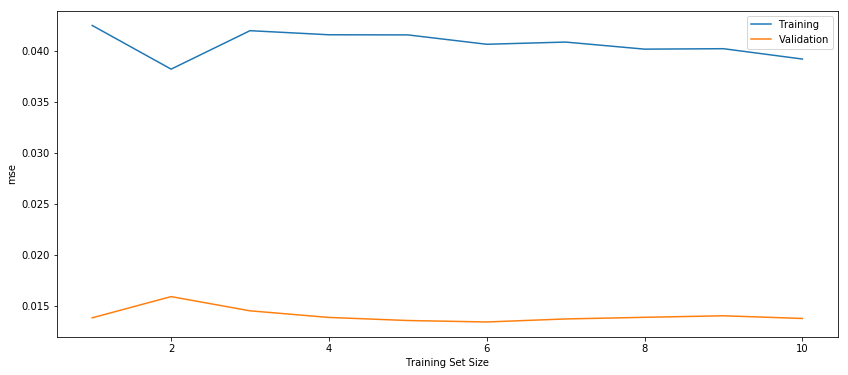

In [5]:
size_percentage = list(range(1, 11))
histories_loss = []
histories_mse = []
for h in histories:
    histories_loss.append(h.history['loss'][-1])
    histories_mse.append(h.history['val_mean_squared_error'][-1])
    
plt.figure(figsize=(14,6))
plt.plot(size_percentage, histories_loss, label='loss score')
plt.plot(size_percentage, histories_mse, label='validation score')
plt.xlabel('Training Set Size')
plt.ylabel('mse')
plt.legend(['Training', 'Validation'], loc='upper right')